# Decision: Where to Go?

 ![alt text](images/spinning-rover.gif)


The goal of this project is to perform autonomous navigation and mapping. You now have the mapping piece and realistically, that means the hard work is done! With each new image you receive from the rover's camera, you will have the opportunity to make a decision about sending commands like throttle, brake and steering. But how to decide what values to send for these commands?

Let's start with steering. There are many ways to approach this, but for starters I'll propose one simple method to decide on a steering angle that will get you up and running with the project. Here we'll consider this image where there is clearly more open ground to the left as seen from the rover's perspective:



 ![alt text](images/angle-example.jpg)

# Average Angle

You have already calculated the x and y positions of navigable terrain pixels in rover space and now you'd like to decide which direction to steer the rover. One simple way to decide is to choose the direction with the clearest path or in other words, the most navigable terrain pixels!

To do this you will first convert your (x, y) pixel positions to [polar](https://en.wikipedia.org/wiki/Polar_coordinate_system) coordinates, where each pixel position is represented by its distance from the origin and angle counterclockwise from the positive x-direction.

Converting to polar coordinates is a simple two-step process:

In [8]:
# Define a function to convert from cartesian to polar coordinates
def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    return dist, angles

Now, assuming you have all the functions defined in previous exercises at our disposal, you can process the above image and plot up the results.

In [9]:
import cv2

def perspect_transform(img, src, dst):
    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped


def color_thresh(img, rgb_thresh=(170, 170, 170)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:, :, 0])
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:, :, 0] > rgb_thresh[0]) \
                   & (img[:, :, 1] > rgb_thresh[1]) \
                   & (img[:, :, 2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select


def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(float)
    return x_pixel, y_pixel

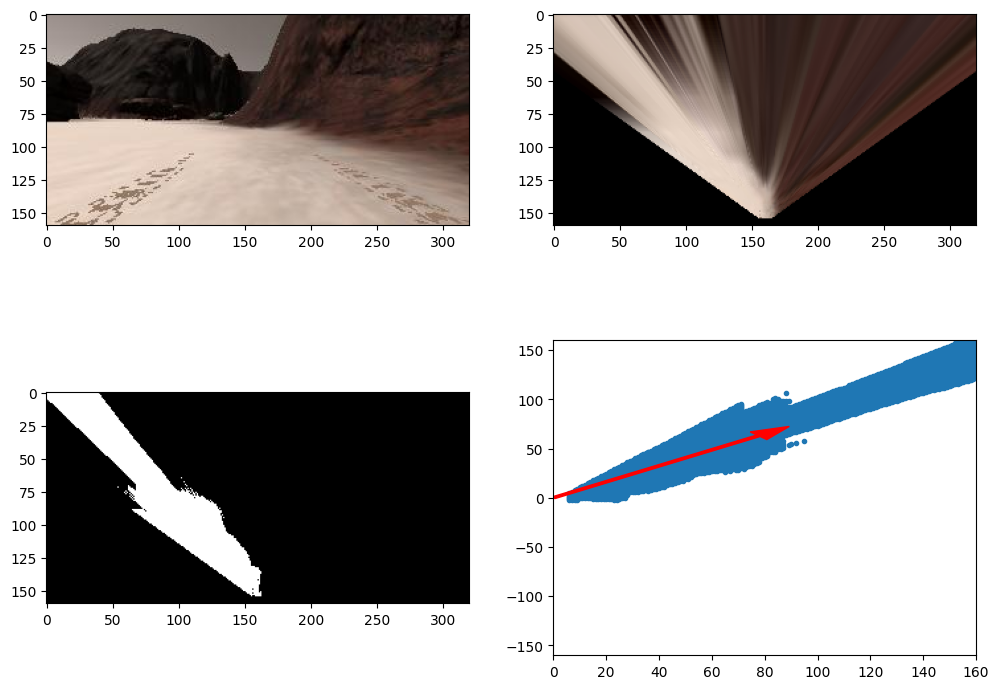

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Uncomment the next line for use in a Jupyter notebook
#%matplotlib inline
import numpy as np

image = mpimg.imread('images/angle-example.jpg')
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301, 140], [200, 96], [118, 96]])
destination = np.float32([[image.shape[1] / 2 - dst_size, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst_size, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst_size, image.shape[0] - 2 * dst_size - bottom_offset],
                          [image.shape[1] / 2 - dst_size, image.shape[0] - 2 * dst_size - bottom_offset],
                          ])

warped = perspect_transform(image, source, destination) # Perform perspective transform
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160)) # Threshold the warped image
xpix, ypix = rover_coords(colorsel)  # Convert to rover-centric coords
distances, angles = to_polar_coords(xpix, ypix) # Convert to polar coords
avg_angle = np.mean(angles) # Compute the average angle

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(colorsel, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(avg_angle)
y_arrow = arrow_length * np.sin(avg_angle)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.show()

The direction (angle) with that represents the average angle of all navigable terrain pixels in the rover's field of view is at roughly 0.7 radians in the plot above.

Given the approximate field of view of the camera, the average values for angle that you get will vary between about $+/- π/4$ radians. The input for steering angles you can send to the rover is in degrees over the range -15 (to the right) to +15 (to the left), so the last step is to choose a conversion between your average angle and the steering angle you want to send to the rover. The simplest thing to do would be to convert to degrees and clip to the range +/- 15 like this:

In [12]:
avg_angle_degrees = avg_angle * 180/np.pi
steering = np.clip(avg_angle_degrees, -15, 15)